In [24]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from funciones_3 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Evaluación de Aceptación de Vehículos. 
Usted trabaja en el equipo de Machine Learning de una empresa que comercializa vehículos online, y se le ha pedido que desarrolle un modelo para predecir el grado de aceptabilidad de vehículos por parte de los clientes.
Para ello le ha sido dado un conjunto de datos recolectados durante 2 años de operación de la empresa, en donde se reporta el precio de venta, costo de mantenimiento, nu ́mero de puertas, capacidad de pasajeros, tamaño del baíl y seguridad estimada de distinos vehículos, así como el grado de aceptación de estos vehículos por parte de los clientes. La aceptación de un vehículo puede interpretarse como la medida en que este cumple con las necesidades, preferencias y requisitos del cliente y se reporta en cuatro categorías: “inaceptable”, “aceptable”, “buena” y “muy buena”. El con- junto de datos se dividió previamente en uno de entrenamiento (car train.csv), uno de validación (car valid.csv) y uno de testeo (car test.csv).
Desarrollar al menos dos modelos predictivos distintos que estimen el nivel de aceptación de un vehículo, en base a sus atributos. Explicar cual de todos los modelos desarrollados se debe poner en producción, teniendo en cuenta que lo que más le interesa a la empresa es identifcar bien los vehiculos que son “inaceptables”, así como los que son “muy buenos”, ya que los primeros representan un cliente insastisfecho, y los segundos son los vehículos que se quieren promocionar más.
Describa claramente cua ́l fue la estrategia y el proceso que llevó a cabo para llegar al modelo que enviará a producción (o sea, el que usted considera “el mejor” modelo de todos).

NOTA: cuando se dice “al menos dos modelos predictivos distintos” esto quiere decir dos modelos con arquitecuras distintas. Por ejemplo, LDA y regresion logística son dos arquitecturas distintas, porque por su estructura de ecuaciones parametrizan el espacio de clasificación de manera diferente, mientras que regresión logistica y red neuronal con activación de salida sigmoide son arquitecturas de alguna manera iguales, ya que la primera es un caso particular de la segunda (regresión logística es esencialmente una red neuronal sin capas ocultas y activación sigmoide). La idea es que generen una diversidad de modelos, y quedarse con el que mejor capacidad predictiva tiene para ese problema en particular.

In [25]:
train = pd.read_csv('/Users/maxi/Downloads/Actuales/ML/ML-TP3/Data/3 - Evaluación de Aceptación de Vehı́culos/car_train.csv')
test = pd.read_csv('/Users/maxi/Downloads/Actuales/ML/ML-TP3/Data/3 - Evaluación de Aceptación de Vehı́culos/car_test.csv')
validation = pd.read_csv('/Users/maxi/Downloads/Actuales/ML/ML-TP3/Data/3 - Evaluación de Aceptación de Vehı́culos/car_valid.csv')

# one hot encoding
train = one_hot_encoder(train, ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])
test = one_hot_encoder(test, ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])
validation = one_hot_encoder(validation, ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])
                                          
# target encoding   # unacc:0, acc: 1, good: 2, vgood: 3
train['acceptability'] = train['acceptability'].map({'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3})
test['acceptability'] = test['acceptability'].map({'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3})
validation['acceptability'] = validation['acceptability'].map({'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3})

# normalize all data
# min_max = get_min_max(train)
# train = min_max_normalize(train, min_max)
# test = min_max_normalize(test, min_max)
# validation = min_max_normalize(validation, min_max)

# if any column has a missing value replace with cero
# train = train.fillna(0)
# test = test.fillna(0)
# validation = validation.fillna(0)

print("train shape: ", train.shape)
print("\ntest shape: ", test.shape)
print("\nvalidation shape: ", validation.shape)

train shape:  (1209, 22)

test shape:  (260, 22)

validation shape:  (259, 22)


En el bloque anterior se bajó la información del dataset. Como todas las variables eran categóricas se pasaron a valores númericos y se realizó one hot encoding para armar un feature con cada clase.

In [26]:
# Identify how many samples we have for each class in the training set
print("train:")
print(train['acceptability'].value_counts())

train:
acceptability
0    847
1    269
2     48
3     45
Name: count, dtype: int64


Las clases están desbalanceadas y tengo interés por lograr clasificar específicamente bien los datos de las clases 0 y 3, pero la 3 es una clase minoritaria. Para mejorar la precisión de mis modelos uso la estrategia de  Oversampling.

In [27]:
# Oversampling: duplico todos los datos de las clases 2 y 3 del train
class_2 = train[train['acceptability'] == 2]
class_3 = train[train['acceptability'] == 3]

double_class_2 = pd.concat([class_2], ignore_index=True)
double_class_3 = pd.concat([class_3], ignore_index=True)

train = pd.concat([train, double_class_2, double_class_3], ignore_index=True)

print("train (after Oversampling):")
print(train['acceptability'].value_counts())

train (after Oversampling):
acceptability
0    847
1    269
2     96
3     90
Name: count, dtype: int64


Ahora el train dataset cuenta con más datos de las clases minoritarias.

In [28]:
X_train = train.drop(columns=['acceptability'])
y_train = train['acceptability'].values

X_test = test.drop(columns=['acceptability'])
y_test = test['acceptability'].values

X_validation = validation.drop(columns=['acceptability'])
y_validation = validation['acceptability'].values

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print("X_validation shape: ", X_validation.shape)
print("y_validation shape: ", y_validation.shape)

pd.set_option('display.max_columns', None)
train.head()
test.head()
validation.head()
# X_train.head()
# y_train

# # show all rows
# pd.set_option('display.max_rows', None)
# train

X_train shape:  (1302, 21)
y_train shape:  (1302,)
X_test shape:  (260, 21)
y_test shape:  (260,)
X_validation shape:  (259, 21)
y_validation shape:  (259,)


,acceptability,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,doors_4,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0
1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
2,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1
3,3,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0
4,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0


## KNN
Prueblo de aplicar un modelo de KNN, este modelo probablemente sea inferior al otro, pero sirve como baseline.

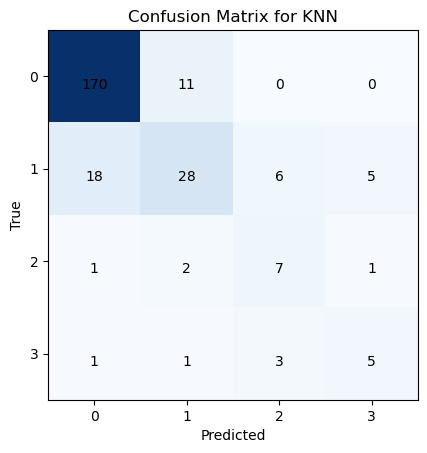

Accuracy:  0.8108108108108109
Precision class 0:  0.9392265193370166
Precision class 3:  0.5


In [40]:
knn_model = KNN(k=3)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_validation)
TP_knn, TN_knn, FP_knn, FN_knn = confusion_matrix(y_validation, y_pred_knn, model_name='KNN')
print("Accuracy: ", accuracy(y_validation, y_pred_knn))
print("Precision class 0: ", prec_class_0(y_validation, y_pred_knn))
print("Precision class 3: ", prec_class_3(y_validation, y_pred_knn))

Se puede observar que el accuracy general es decente, el accuracy de la clase 0 es el más alto, pero el accuracy para la clase 3 es de un 50%, lo cual es inaceptable.

## Árbol de Decisión
Pruebo de aplicar un Árbol de decisión. Nuevamente no pretendo que este sea el mejor modelo, sino que lo implemento para ver como funciona y que resultados se logran con un árbol solo antes de aprovechar el uso de métodos de ensamble.


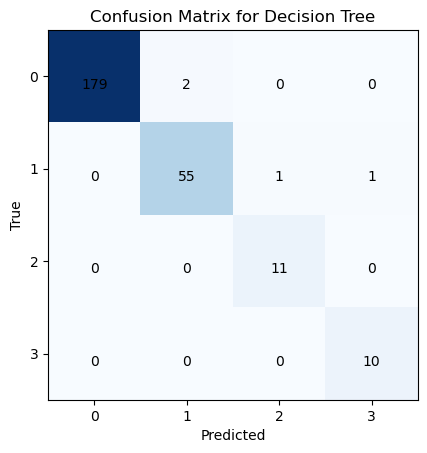

Accuracy:  0.9845559845559846
Precision class 0:  0.988950276243094
Precision class 3:  1.0


In [41]:
dt_model = DecisionTree(max_depth=10)
dt_model.fit(X_train.values, y_train)
y_pred_dt = dt_model.predict(X_validation.values)
cf_dt = confusion_matrix(y_validation, y_pred_dt, model_name='Decision Tree')
print("Accuracy: ", accuracy(y_validation, y_pred_dt))
print("Precision class 0: ", prec_class_0(y_validation, y_pred_dt))
print("Precision class 3: ", prec_class_3(y_validation, y_pred_dt))


En este caso todos los accuracies calculados son muy altos y parecería un modelo aceptable para poner en producción. Pero antes hay que hacer mas pruebas.

## Random Forest
Pruebo de aplicar un random forest. Espero que este sea el modelo que de los mejores resultados.

100%|██████████| 100/100 [00:07<00:00, 13.31it/s]


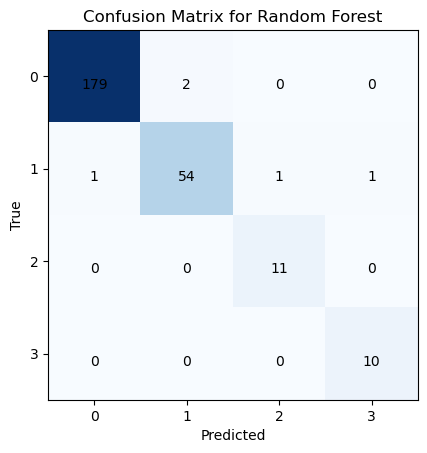

Accuracy:  0.9806949806949807
Precision class 0:  0.988950276243094
Precision class 3:  1.0


In [39]:
rf_model = RandomForest(n_trees=100, max_depth=10)
rf_model.fit(X_train.values, y_train)
y_pred_rf = rf_model.predict(X_validation.values)
cf_rf = confusion_matrix(y_validation, y_pred_rf, model_name='Random Forest')
print("Accuracy: ", accuracy(y_validation, y_pred_rf))
print("Precision class 0: ", prec_class_0(y_validation, y_pred_rf))
print("Precision class 3: ", prec_class_3(y_validation, y_pred_rf))

En este caso se puede observar que las predicciones, mejoraron un poco respecto de las anteriores y son casi perfectas (en el conjunto de validación).

In [48]:
# results on test set
print("Results on test set:")
y_pred = knn_model.predict(X_test)
print("KNN")
print("Accuracy: ", accuracy(y_test, y_pred))
print("Precision class 0: ", prec_class_0(y_test, y_pred))
print("Precision class 3: ", prec_class_3(y_test, y_pred))

y_pred = dt_model.predict(X_test.values)
print("\nDecision Tree")
print("Accuracy: ", accuracy(y_test, y_pred))
print("Precision class 0: ", prec_class_0(y_test, y_pred))
print("Precision class 3: ", prec_class_3(y_test, y_pred))

y_pred = rf_model.predict(X_test.values)
print("\nRandom Forest")
print("Accuracy: ", accuracy(y_test, y_pred))
print("Precision class 0: ", prec_class_0(y_test, y_pred))
print("Precision class 3: ", prec_class_3(y_test, y_pred))

Results on test set:
KNN
Accuracy:  0.8346153846153846
Precision class 0:  0.9340659340659341
Precision class 3:  0.8

Decision Tree
Accuracy:  0.9807692307692307
Precision class 0:  0.978021978021978
Precision class 3:  1.0

Random Forest
Accuracy:  0.9769230769230769
Precision class 0:  0.9835164835164835
Precision class 3:  1.0


Usando RandomForest se están obteniendo excelentes resultados. (Me genera dudas porqué el árbol de decisión da tan similar). Realizó cross-validation con el modelo de Random Forest para encontrar los mejores hiperparámetros para este modelo. Para definir que hiperparámetros son los óptimos tomo como métrica el promedio entre la precisión de las predicciones de clase 0 y 3, que fueron definidas como las clases mas importantes de identificar correctamente.  

In [43]:
# max_depths = [5, 8, 10, 12, 15]
# forest_sizes = [10, 50, 100, 200]

max_depths = [5, 10, 15, 20]
forest_sizes = [10, 50, 100, 200]

In [44]:
acc_train, acc_test, acc_0, acc_3 = cross_validation(X_train, y_train, max_depths, forest_sizes, k=10)

100%|██████████| 200/200 [00:15<00:00, 13.07it/s]
Max Depths: 4it [15:27, 231.80s/it]


In [45]:
best_accuracy = 0
best_hparams = None

for i, depth in enumerate(max_depths):
    for j, forest_size in enumerate(forest_sizes):
        avg_train_accuracy = np.mean(acc_train[i * len(forest_sizes) + j])
        avg_test_accuracy = np.mean(acc_test[i * len(forest_sizes) + j])

        avg_train_acc_0 = np.mean(acc_0[i * len(forest_sizes) + j])
        avg_train_acc_3 = np.mean(acc_3[i * len(forest_sizes) + j])
        avg_test_acc_0 = np.mean(acc_0[i * len(forest_sizes) + j])
        avg_test_acc_3 = np.mean(acc_3[i * len(forest_sizes) + j])

        avg_train_top_classes_acc = (avg_train_acc_0 + avg_train_acc_3) / 2
        avg_test_top_classes_acc = (avg_test_acc_0 + avg_test_acc_3) / 2
        
        # choose the best hyperparameters based on the average accuracy of the top classes (0 and 3)
        if avg_test_top_classes_acc > best_accuracy:
            best_accuracy = avg_test_top_classes_acc
            best_hparams = (depth, forest_size)

print("Best hyperparameters:", best_hparams)
print("Best average test accuracy:", best_accuracy)
print("Best average test precision (0):", avg_test_acc_0)
print("Best average test precision (3):", avg_test_acc_3)


Best hyperparameters: (10, 100)
Best average test accuracy: 0.9930053379820293
Best average test precision (0): 0.979684588916465
Best average test precision (3): 1.0


100%|██████████| 100/100 [00:07<00:00, 14.03it/s]


Validation set


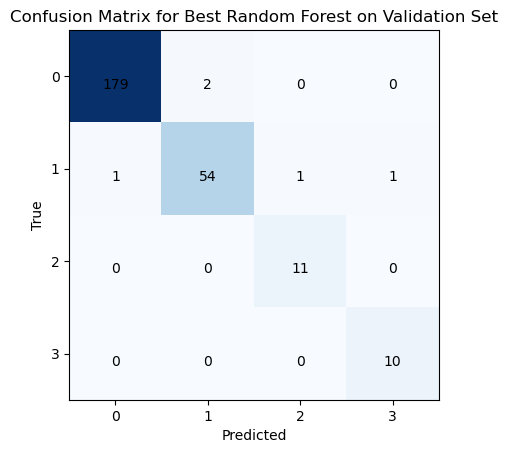

Accuracy:  0.9806949806949807
Precision class 0:  0.988950276243094
Precision class 3:  1.0

Test set


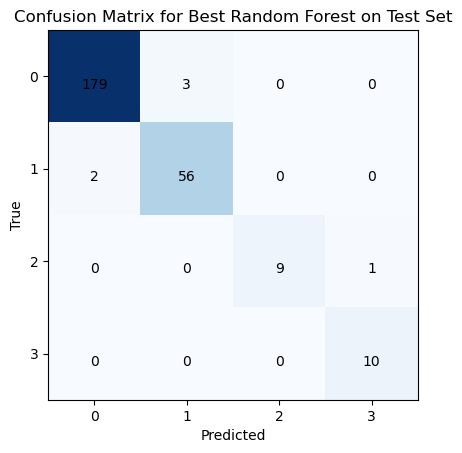

Accuracy:  0.9769230769230769
Precision class 0:  0.9835164835164835
Precision class 3:  1.0


In [46]:
# train model with best hyperparameters
rf_model = RandomForest(n_trees=best_hparams[1], max_depth=best_hparams[0])
rf_model.fit(X_train.values, y_train)
y_pred = rf_model.predict(X_validation.values)
y_pred_test = rf_model.predict(X_test.values)

print("Validation set")
confusion_matrix(y_validation, y_pred, model_name='Best Random Forest on Validation Set')
print("Accuracy: ", accuracy(y_validation, y_pred))
print("Precision class 0: ", prec_class_0(y_validation, y_pred))
print("Precision class 3: ", prec_class_3(y_validation, y_pred))
# print("Precision: ", precision(y_validation, y_pred))
# print("Recall: ", recall(y_validation, y_pred))
# print("F1 Score: ", f1(y_validation, y_pred))
# print(f"confusion matrix: {confusion_matrix(y_validation, y_pred)}")

print("\nTest set")
confusion_matrix(y_test, y_pred_test, model_name='Best Random Forest on Test Set')
print("Accuracy: ", accuracy(y_test, y_pred_test))
print("Precision class 0: ", prec_class_0(y_test, y_pred_test))
print("Precision class 3: ", prec_class_3(y_test, y_pred_test))
# print("Precision: ", precision(y_test, y_pred_test))
# print("Recall: ", recall(y_test, y_pred_test))
# print("F1 Score: ", f1(y_test, y_pred_test))
# print(f"confusion matrix: {confusion_matrix(y_test, y_pred_test)}")

Los resultados obtenidos son casi perfectos, en el dataset de validación solo 5 datos de 259 fueron clasificados incorrectamente y en el dataset de entrenamiento de 260 datos solo 6 muestras fueron mal catalogadas. Además, en el dataset de validación solo 2 muestras de la clase 0 fueron clasificadas erróneamente, mientras que las muestras de clase 3 fueron todas predichas de forma acorde. 